<a href="https://colab.research.google.com/github/Kidara/AMD-SM2L-2020-21-project/blob/main/Glasses_or_No_Glasses_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Provide an authentication 'kaggle.json' file

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# INIT

In [ ]:
#@markdown Install dependencies
from IPython import display

!pip install kaggle
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install keras-tuner
!pip install split-folders
!pip install visualkeras

display.Javascript("google.colab.output.setIframeHeight('200px');")

     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 102kB 5.8MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=e8cc00fd52d2f44585be7a43aa4bd4eaddf267783c03e92695a90a4caafa9282
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy
     |████████████████████████████████| 798kB 8.4MB/s 


<IPython.core.display.Javascript object>

In [ ]:
#@markdown Imports

import sys, shutil, os, portpicker, gc, time, glob, pickle

import numpy as np
import pandas as pd
from dask import dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import Dense, Dropout, Concatenate, Activation,\
      LayerNormalization, BatchNormalization, Rescaling
from keras.preprocessing.image import ImageDataGenerator,\
      image_dataset_from_directory
from keras import regularizers, activations
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from keras.utils.vis_utils import plot_model

import keras_tuner as kt
import splitfolders
from sklearn.model_selection import train_test_split

import visualkeras

%matplotlib inline

# Download dataset
Provide an authentication 'kaggle.json' file

In [ ]:
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses

Saving kaggle.json to kaggle.json
100% 6.11G/6.11G [02:10<00:00, 60.2MB/s]
100% 6.11G/6.11G [02:11<00:00, 50.1MB/s]


In [ ]:
!unzip -q glasses-or-no-glasses.zip -d glasses-or-no-glasses

In [ ]:
#Remove zip file to free space
if os.path.exists('./glasses-or-no-glasses') and os.path.exists('./glasses-or-no-glasses.zip'):
  !rm glasses-or-no-glasses.zip

# Prepare dataset

In [ ]:
#@markdown Load CSV
# Load CSV with Dask to perform distributed loading and lazy evaluation, without
# storing the whole CSV in memory
latent_features_csv = dd.read_csv("./glasses-or-no-glasses/train.csv")

In [ ]:
#@markdown Divide images in glasses and no-glasses folders

old_path = './glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/'

path = './images/glasses'
if not os.path.exists(path):
    os.makedirs(path)
path = './images/no-glasses'
if not os.path.exists(path):
    os.makedirs(path)

# We assume that ['id','glasses'] can fit all in memory
for glasses_label in latent_features_csv[['id','glasses']].iterrows():
    old_image_path = os.path.join(old_path, 'face-' + str(glasses_label[1][0]) + '.png')
    new_path = ''
    if glasses_label[1][1] == 0:
        new_path = './images/no-glasses'
    else:
        new_path = './images/glasses'
    new_image_path = os.path.join(new_path, str(glasses_label[1][0]) + '.png')
    shutil.copyfile(old_image_path, new_image_path)

In [ ]:
#@markdown Check unbalancedness of data
n_glasses = latent_features_csv['glasses'].sum()
n_total = latent_features_csv['glasses'].count()
glasses_over_total = (n_glasses/n_total).compute()
print("There are {:.2f} 'glasses' labels every 'no glasses' label."\
      .format(glasses_over_total/(1-glasses_over_total)))
print("The dataset is not so unbalanced, we can keep it as it is.")

In [ ]:
#@markdown We split images in 'train' 'val' 'test' folders due to the data
#@markdown pipeline used later.

RANDOM_SEED = 1337 #@param

path = './glasses-or-no-glasses/faces-spring-2020'
if os.path.exists(path):
    shutil.rmtree(path)
path = './images_train-val-test'
if os.path.exists(path):
    shutil.rmtree(path)
splitfolders.ratio("images", output="images_train-val-test", seed=RANDOM_SEED,\
                   ratio=(.8, .1, .1), group_prefix=None)

Copying files: 4500 files [02:20, 31.93 files/s]


# Image size analysis

We create a python script to send it to the replicas for distributed computing.  
We also expose the image size parameter as a command line argument, in order to test different size configurations.  
For this step we keep the number of random trials as low as possible, since it already take a long time.

In [ ]:
#@title main.py
%%writefile main.py

import sys, os, shutil, glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Input, Sequential
from keras.preprocessing.image import image_dataset_from_directory
#from keras.layers import InputLayer, Dense, ReLU, Conv2D, MaxPooling2D,\
#    AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Resizing, Rescaling,\
    RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast
from keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner as kt


print("KerasTuner Tuner ID: {}".format(os.environ['KERASTUNER_TUNER_ID']))
print("KerasTuner Oracle IP: {}".format(os.environ['KERASTUNER_ORACLE_IP']))
print("KerasTuner Oracle Port: {}".format(os.environ['KERASTUNER_ORACLE_PORT']))


#######################################
############ SET VARIABLES ############
#######################################
strategy = tf.distribute.MirroredStrategy()

#@markdown Preprocessing:
IMAGE_DIM = 64 #@param {type:"integer"}
if len(sys.argv)>1:
    IMAGE_DIM = int(sys.argv[1]) #Override IMAGE_DIM when launching the script
BATCH_SIZE_PER_REPLICA =  16#@param {type:"integer"}
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

TRAINING_DIR = './images_train-val-test/train' #@param {type:"string"}
VALIDATION_DIR = './images_train-val-test/val' #@param {type:"string"}

RECACHE = False #@param {type:"boolean"}
TRAIN_CACHE_PATH = './train_cache_' #@param {type:"string"}
VAL_CACHE_PATH = './validation_cache_' #@param {type:"string"}

#@markdown Keras Tuner:
RANDOM_TRIALS =  5 #@param {type:"integer"}
RANDOM_SEED = 1337 #@param {type:"integer"}
EPOCHS = 50 #@param {type:"integer"}
EARLYSTOPPING_PATIENCE = 5 #@param {type:"integer"}
#######################################
#######################################


#######################################
########## HELPER FUNCTIONS ###########
#######################################
def get_train_val_datasets(image_dim, batch_size, training_dir, validation_dir,
                           recache, train_cache_path, val_cache_path):
    
    train_cache_path = train_cache_path + str(image_dim)
    val_cache_path = val_cache_path + str(image_dim)

    #Since caching doesn't overwrite old cache,
    #we need to clear old cache before writing it again
    if(recache):
        for f in glob.glob(train_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)
        for f in glob.glob(val_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)

    rescale = keras.Sequential([
        #Normalize values between 0 and 1
        Rescaling(1./255)
    ])

    train_ds = image_dataset_from_directory(
        directory=training_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        #resizing is done in the dataset to reduce the data sent to the replicas
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    train_ds = train_ds.map(lambda image, label:\
                            (rescale(image, training=True), label),
                            num_parallel_calls=tf.data.AUTOTUNE)
    #caching to file speeds up consequent readings (used with small dataset)
    train_ds = train_ds.cache(train_cache_path)
    train_ds = train_ds.shuffle(buffer_size=batch_size)
    #prefetch makes CPU work in parallel with GPU
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    validation_ds = image_dataset_from_directory(
        directory=validation_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    validation_ds = validation_ds.map(lambda image, label:\
                                      (rescale(image, training=True), label),
                                      num_parallel_calls=tf.data.AUTOTUNE)
    validation_ds = validation_ds.cache(val_cache_path)
    validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, validation_ds


def augmentation_model():
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))

    #Augmentation layers (they are automatically disabled during testing)
    x = RandomFlip(mode="horizontal")(input)
    x = RandomTranslation(height_factor=0.2,
                          width_factor=0.2,
                          fill_mode="reflect")(x)
    x = RandomRotation(factor=0.125, #Max +-45degrees
                       fill_mode="reflect")(x)
    x = RandomZoom(height_factor=0.25)(x)

    return tf.keras.Model(input,x)


def plot_augmented_images(dataset):
    samples = dataset.take(1)
    augmentation = augmentation_model()

    for sample in samples:
        images = sample[0]
        aug_images = augmentation(images)
        for image in aug_images:
            plt.imshow((image*255).numpy().astype(np.uint8))
            plt.show()


def build_model(hp):
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
  
    augmentation = augmentation_model()
    x = augmentation(input)

    for i in range(hp.Int("conv_layers", 1, 5, default=5)):
        x = keras.layers.Conv2D(
                filters=hp.Int("filters_" + str(i), 8, 64, step=8, default=16),
                kernel_size=3,
                activation="relu",
                padding="same",
            )(x)

        if hp.Choice("pooling_" + str(i), ["max", "avg"]) == "max":
            x = keras.layers.MaxPooling2D()(x)
        else:
            x = keras.layers.AveragePooling2D()(x)

        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    if hp.Choice("global_pooling", ["max", "avg"]) == "max":
        x = keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input, output)

    optimizer = hp.Choice("optimizer", ["adam", "sgd"])
    model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model
#######################################
#######################################


#######################################
####### HYPERPARAMETERS SEARCH ########
#######################################
save_path = './results_dir/glasses_noglasses_'+str(IMAGE_DIM)
if os.path.exists(save_path):
    shutil.rmtree(save_path)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=RANDOM_TRIALS,
    seed=RANDOM_SEED,
    distribution_strategy=strategy,
    directory="results_dir",
    project_name="glasses_noglasses_"+str(IMAGE_DIM),
    overwrite=False,
)

train_ds, validation_ds = get_train_val_datasets(
    image_dim=IMAGE_DIM,
    batch_size=BATCH_SIZE,
    training_dir=TRAINING_DIR,
    validation_dir=VALIDATION_DIR,
    recache=RECACHE,
    train_cache_path=TRAIN_CACHE_PATH,
    val_cache_path=VAL_CACHE_PATH
)

#tensorboard_logs = './logs'
#if os.path.exists(tensorboard_logs):
#    shutil.rmtree(tensorboard_logs)

earlystopping_callback = EarlyStopping("val_accuracy",
                                       patience=EARLYSTOPPING_PATIENCE,
                                       restore_best_weights=True)
#tensorboard_callback = TensorBoard(log_dir=tensorboard_logs)
tuner.search(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[earlystopping_callback],
)
#######################################
#######################################


#######################################
############ SAVE SUMMARY #############
#######################################
if os.environ['KERASTUNER_TUNER_ID'] == "chief":
    save_path = './trials_{}_summary.pkl'.format(IMAGE_DIM)
    if os.path.exists(save_path):
        df = pd.read_pickle(save_path)
    else:
        df = pd.DataFrame(columns = tuner.get_best_hyperparameters()[0].values.keys())
        df.insert(len(df.columns), 'image_size', [])
        df.insert(len(df.columns), 'val_accuracy', [])
    for trial in tuner.oracle.trials.values():
        row = trial.hyperparameters.values.copy()
        row['image_size'] = IMAGE_DIM
        row['val_accuracy'] = trial.score
        df = df.append(row, ignore_index=True)
    df.to_pickle('./trials_{}_summary.pkl'.format(IMAGE_DIM))
#######################################
#######################################

Writing main.py


## 64x64 images

In [ ]:
%killbgscripts

All background processes were killed.


In [ ]:
#Set environmental variables to run distributed KerasTuner

#Environmental variables for the main worker (collector)
os.environ['KERASTUNER_TUNER_ID'] = "chief"
os.environ['KERASTUNER_ORACLE_IP'] = "localhost"
os.environ['KERASTUNER_ORACLE_PORT'] = "{}".format(portpicker.pick_unused_port())

In [ ]:
%%bash --bg
python main.py 64 &> chief_64.log

Starting job # 0 in a separate thread.


In [ ]:
time.sleep(2)

In [ ]:
#Environmental variables for the side worker
os.environ['KERASTUNER_TUNER_ID'] = "tuner0"

In [ ]:
# We don't execute this process in backgroud because we want to know when it is
# finished.
# Tecnically this process should be run on every machine in our cluster, but
# we run it locally since we don't have any cluster available.
%%bash
python main.py 64 &> tuner0_64.log

In [ ]:
#Wait until chief worker collect and write results
time.sleep(10)

## 128x128 images

In [ ]:
%killbgscripts

All background processes were killed.


In [ ]:
os.environ['KERASTUNER_TUNER_ID'] = "chief"
os.environ['KERASTUNER_ORACLE_IP'] = "localhost"
os.environ['KERASTUNER_ORACLE_PORT'] = "{}".format(portpicker.pick_unused_port())

In [ ]:
%%bash --bg
python main.py 128 &> chief_128.log

Starting job # 2 in a separate thread.


In [ ]:
time.sleep(2)

In [ ]:
os.environ['KERASTUNER_TUNER_ID'] = "tuner0"

In [ ]:
%%bash
python main.py 128 &> tuner0_128.log

In [ ]:
time.sleep(10)

## 256x256 images

In [ ]:
%killbgscripts

All background processes were killed.


In [ ]:
os.environ['KERASTUNER_TUNER_ID'] = "chief"
os.environ['KERASTUNER_ORACLE_IP'] = "localhost"
os.environ['KERASTUNER_ORACLE_PORT'] = "{}".format(portpicker.pick_unused_port())

In [ ]:
%%bash --bg
python main.py 256 &> chief_256.log

Starting job # 3 in a separate thread.


In [ ]:
time.sleep(2)

In [ ]:
os.environ['KERASTUNER_TUNER_ID'] = "tuner0"

In [ ]:
%%bash
python main.py 256 &> tuner0_256.log

In [ ]:
time.sleep(10)

## Results analysis

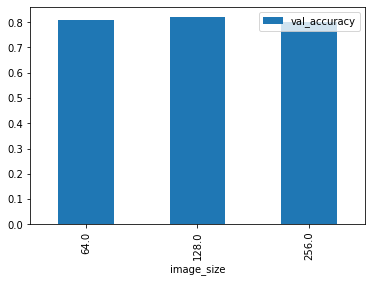

In [ ]:
#@markdown From the following plot we can see that the image size is not
#@markdown particularly correlated with the validation accuracy (at least with
#@markdown the sizes tested).  

#Retrieve results
df_64 = pd.read_pickle('./trials_64_summary.pkl')
df_128 = pd.read_pickle('./trials_128_summary.pkl')
df_256 = pd.read_pickle('./trials_256_summary.pkl')

#Merge and plot results
df = pd.DataFrame(columns = df_64.columns)
df = df.append(df_64).append(df_128).append(df_256)
df.groupby('image_size').mean().plot.bar()
plt.show()

Training large images is expensive: the computational cost grows quadratic in the image size, since images have two dimensions. Given that the image sizes tested don't seem to be correlated with validation accuracy, subsequent analyzes will use 64x64 images.

# Hyperparameters random search

We now try to find the optimal number of convolutional layers and the optimal optimizer.  
It's hard to find the optimal value of the other hyperparameters, since they strictly depends on the number of convolutional layers.

In [ ]:
#@title main.py
%%writefile main.py

import sys, os, shutil, glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Input, Sequential
from keras.preprocessing.image import image_dataset_from_directory
#from keras.layers import InputLayer, Dense, ReLU, Conv2D, MaxPooling2D,\
#    AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Resizing, Rescaling,\
    RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast
from keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner as kt


print("KerasTuner Tuner ID: {}".format(os.environ['KERASTUNER_TUNER_ID']))
print("KerasTuner Oracle IP: {}".format(os.environ['KERASTUNER_ORACLE_IP']))
print("KerasTuner Oracle Port: {}".format(os.environ['KERASTUNER_ORACLE_PORT']))


#######################################
############ SET VARIABLES ############
#######################################
strategy = tf.distribute.MirroredStrategy()

#@markdown Preprocessing:
IMAGE_DIM = 64 #@param {type:"integer"}
if len(sys.argv)>1:
    IMAGE_DIM = int(sys.argv[1]) #Override IMAGE_DIM when launching the script
BATCH_SIZE_PER_REPLICA =  64#@param {type:"integer"}
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

TRAINING_DIR = './images_train-val-test/train' #@param {type:"string"}
VALIDATION_DIR = './images_train-val-test/val' #@param {type:"string"}

RECACHE = True #@param {type:"boolean"}
TRAIN_CACHE_PATH = './train_cache_' #@param {type:"string"}
VAL_CACHE_PATH = './validation_cache_' #@param {type:"string"}

#@markdown Keras Tuner:
RANDOM_TRIALS =  100#@param {type:"integer"}
RANDOM_SEED = 1337 #@param {type:"integer"}
EPOCHS = 50 #@param {type:"integer"}
EARLYSTOPPING_PATIENCE = 10 #@param {type:"integer"}
#######################################
#######################################


#######################################
########## HELPER FUNCTIONS ###########
#######################################
def get_train_val_datasets(image_dim, batch_size, training_dir, validation_dir,
                           recache, train_cache_path, val_cache_path):
    
    train_cache_path = train_cache_path + str(image_dim)
    val_cache_path = val_cache_path + str(image_dim)

    #Since caching doesn't overwrite old cache,
    #we need to clear old cache before writing it again
    if(recache):
        for f in glob.glob(train_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)
        for f in glob.glob(val_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)

    rescale = keras.Sequential([
        #Normalize values between 0 and 1
        Rescaling(1./255)
    ])

    train_ds = image_dataset_from_directory(
        directory=training_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        #resizing is done in the dataset to reduce the data sent to the replicas
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    train_ds = train_ds.map(lambda image, label:\
                            (rescale(image, training=True), label),
                            num_parallel_calls=tf.data.AUTOTUNE)
    #caching to file speeds up consequent readings (used with small dataset)
    train_ds = train_ds.cache(train_cache_path)
    train_ds = train_ds.shuffle(buffer_size=batch_size)
    #prefetch makes CPU work in parallel with GPU
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    validation_ds = image_dataset_from_directory(
        directory=validation_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    validation_ds = validation_ds.map(lambda image, label:\
                                      (rescale(image, training=True), label),
                                      num_parallel_calls=tf.data.AUTOTUNE)
    validation_ds = validation_ds.cache(val_cache_path)
    validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, validation_ds


def augmentation_model():
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))

    #Augmentation layers (they are automatically disabled during testing)
    x = RandomFlip(mode="horizontal")(input)
    x = RandomTranslation(height_factor=0.2,
                          width_factor=0.2,
                          fill_mode="reflect")(x)
    x = RandomRotation(factor=0.125, #Max +-45degrees
                       fill_mode="reflect")(x)
    x = RandomZoom(height_factor=0.25)(x)

    return tf.keras.Model(input,x)


def plot_augmented_images(dataset):
    samples = dataset.take(1)
    augmentation = augmentation_model()

    for sample in samples:
        images = sample[0]
        aug_images = augmentation(images)
        for image in aug_images:
            plt.imshow((image*255).numpy().astype(np.uint8))
            plt.show()


def build_model(hp):
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
  
    augmentation = augmentation_model()
    x = augmentation(input)

    for i in range(hp.Int("conv_layers", 1, 5, default=5)):
        x = keras.layers.Conv2D(
                filters=hp.Int("filters_" + str(i), 8, 64, step=8, default=16),
                kernel_size=3,
                activation="relu",
                padding="same",
            )(x)

        if hp.Choice("pooling_" + str(i), ["max", "avg"]) == "max":
            x = keras.layers.MaxPooling2D()(x)
        else:
            x = keras.layers.AveragePooling2D()(x)

        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    if hp.Choice("global_pooling", ["max", "avg"]) == "max":
        x = keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input, output)

    optimizer = hp.Choice("optimizer", ["adam", "sgd"])
    model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model
#######################################
#######################################


#######################################
####### HYPERPARAMETERS SEARCH ########
#######################################
save_path = './results_dir/glasses_noglasses_'+str(IMAGE_DIM)
if os.path.exists(save_path):
    shutil.rmtree(save_path)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=RANDOM_TRIALS,
    seed=RANDOM_SEED,
    distribution_strategy=strategy,
    directory="results_dir",
    project_name="glasses_noglasses_"+str(IMAGE_DIM),
    overwrite=False,
)

train_ds, validation_ds = get_train_val_datasets(
    image_dim=IMAGE_DIM,
    batch_size=BATCH_SIZE,
    training_dir=TRAINING_DIR,
    validation_dir=VALIDATION_DIR,
    recache=RECACHE,
    train_cache_path=TRAIN_CACHE_PATH,
    val_cache_path=VAL_CACHE_PATH
)

#tensorboard_logs = './logs'
#if os.path.exists(tensorboard_logs):
#    shutil.rmtree(tensorboard_logs)

earlystopping_callback = EarlyStopping("val_accuracy",
                                       patience=EARLYSTOPPING_PATIENCE,
                                       restore_best_weights=True)
#tensorboard_callback = TensorBoard(log_dir=tensorboard_logs)
tuner.search(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[earlystopping_callback],
)
#######################################
#######################################


#######################################
############ SAVE SUMMARY #############
#######################################
if os.environ['KERASTUNER_TUNER_ID'] == "chief":
    save_path = './trials_{}_summary.pkl'.format(IMAGE_DIM)
    if os.path.exists(save_path):
        df = pd.read_pickle(save_path)
    else:
        df = pd.DataFrame(columns = tuner.get_best_hyperparameters()[0].values.keys())
        df.insert(len(df.columns), 'image_size', [])
        df.insert(len(df.columns), 'val_accuracy', [])
    for trial in tuner.oracle.trials.values():
        row = trial.hyperparameters.values.copy()
        row['image_size'] = IMAGE_DIM
        row['val_accuracy'] = trial.score
        df = df.append(row, ignore_index=True)
    df.to_pickle('./trials_{}_summary.pkl'.format(IMAGE_DIM))
#######################################
#######################################

Overwriting main.py


## 64x64 images

In [ ]:
%killbgscripts

All background processes were killed.


In [ ]:
#Set environmental variables to run distributed KerasTuner

#Environmental variables for the main worker (collector)
os.environ['KERASTUNER_TUNER_ID'] = "chief"
os.environ['KERASTUNER_ORACLE_IP'] = "localhost"
os.environ['KERASTUNER_ORACLE_PORT'] = "{}".format(portpicker.pick_unused_port())

In [ ]:
%%bash --bg
python main.py 64 &> chief_64.log

Starting job # 5 in a separate thread.


In [ ]:
time.sleep(2)

In [ ]:
#Environmental variables for the side worker
os.environ['KERASTUNER_TUNER_ID'] = "tuner0"

In [ ]:
%%bash
python main.py 64 &> tuner0_64.log

In [ ]:
time.sleep(10)

## Results analysis

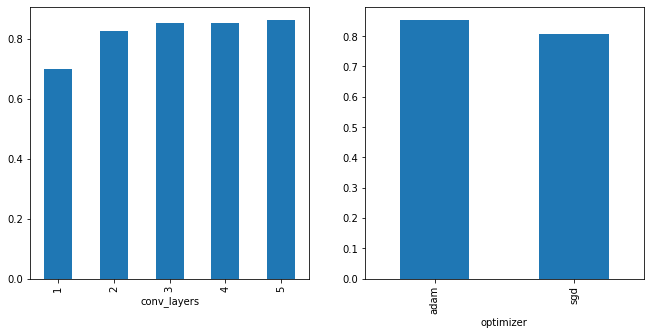

In [ ]:
#@markdown From the following plots we can see that ['conv_layers' = 3] and 
#@markdown ['optimizer' = 'adam'] seem to be optimal choices for the number of 
#@markdown convolutional layers and the optimizer, respectively.
df = pd.read_pickle('./trials_64_summary.pkl')

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(11, 5)
axs.ravel()
df.groupby('conv_layers').mean()['val_accuracy'].plot.bar(ax = axs[0])
df.groupby('optimizer').mean()['val_accuracy'].plot.bar(ax = axs[1])
plt.show()

# Average ensemble model
We now perform the last random search with the new optimal choices made, we select a subset of the trained models to be part of an average ensemble model.
The latter will be evaluated on the test set for the final accuracy score.

In [ ]:
#@title main.py
%%writefile main.py

import sys, os, shutil, glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Input, Sequential
from keras.preprocessing.image import image_dataset_from_directory
#from keras.layers import InputLayer, Dense, ReLU, Conv2D, MaxPooling2D,\
#    AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Resizing, Rescaling,\
    RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast
from keras.callbacks import EarlyStopping, TensorBoard
import keras_tuner as kt


print("KerasTuner Tuner ID: {}".format(os.environ['KERASTUNER_TUNER_ID']))
print("KerasTuner Oracle IP: {}".format(os.environ['KERASTUNER_ORACLE_IP']))
print("KerasTuner Oracle Port: {}".format(os.environ['KERASTUNER_ORACLE_PORT']))


#######################################
############ SET VARIABLES ############
#######################################
strategy = tf.distribute.MirroredStrategy()

#@markdown Preprocessing:
IMAGE_DIM = 64 #@param {type:"integer"}
if len(sys.argv)>1:
    IMAGE_DIM = int(sys.argv[1]) #Override IMAGE_DIM when launching the script
BATCH_SIZE_PER_REPLICA =  64#@param {type:"integer"}
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

TRAINING_DIR = './images_train-val-test/train' #@param {type:"string"}
VALIDATION_DIR = './images_train-val-test/val' #@param {type:"string"}

RECACHE = False #@param {type:"boolean"}
TRAIN_CACHE_PATH = './train_cache_' #@param {type:"string"}
VAL_CACHE_PATH = './validation_cache_' #@param {type:"string"}

#@markdown Keras Tuner:
RANDOM_TRIALS =  150#@param {type:"integer"}
RANDOM_SEED = 1337 #@param {type:"integer"}
EPOCHS = 100 #@param {type:"integer"}
EARLYSTOPPING_PATIENCE = 10 #@param {type:"integer"}

#@markdown Saves:
SAVED_MODELS = 100 #@param {type:"integer"}
#######################################
#######################################


#######################################
########## HELPER FUNCTIONS ###########
#######################################
def get_train_val_datasets(image_dim, batch_size, training_dir, validation_dir,
                           recache, train_cache_path, val_cache_path):
    
    train_cache_path = train_cache_path + str(image_dim)
    val_cache_path = val_cache_path + str(image_dim)

    #Since caching doesn't overwrite old cache,
    #we need to clear old cache before writing it again
    if(recache):
        for f in glob.glob(train_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)
        for f in glob.glob(val_cache_path+".*"):
            if os.path.exists(f):
                os.remove(f)

    rescale = keras.Sequential([
        #Normalize values between 0 and 1
        Rescaling(1./255)
    ])

    train_ds = image_dataset_from_directory(
        directory=training_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        #resizing is done in the dataset to reduce the data sent to the replicas
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    train_ds = train_ds.map(lambda image, label:\
                            (rescale(image, training=True), label),
                            num_parallel_calls=tf.data.AUTOTUNE)
    #caching to file speeds up consequent readings (used with small dataset)
    train_ds = train_ds.cache(train_cache_path)
    train_ds = train_ds.shuffle(buffer_size=batch_size)
    #prefetch makes CPU work in parallel with GPU
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    validation_ds = image_dataset_from_directory(
        directory=validation_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=(image_dim, image_dim),
        interpolation='nearest')
    validation_ds = validation_ds.map(lambda image, label:\
                                      (rescale(image, training=True), label),
                                      num_parallel_calls=tf.data.AUTOTUNE)
    validation_ds = validation_ds.cache(val_cache_path)
    validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_ds, validation_ds


def augmentation_model():
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))

    #Augmentation layers (they are automatically disabled during testing)
    x = RandomFlip(mode="horizontal")(input)
    x = RandomTranslation(height_factor=0.2,
                          width_factor=0.2,
                          fill_mode="reflect")(x)
    x = RandomRotation(factor=0.125, #Max +-45degrees
                       fill_mode="reflect")(x)
    x = RandomZoom(height_factor=0.25)(x)

    return tf.keras.Model(input,x)


def plot_augmented_images(dataset):
    samples = dataset.take(1)
    augmentation = augmentation_model()

    for sample in samples:
        images = sample[0]
        aug_images = augmentation(images)
        for image in aug_images:
            plt.imshow((image*255).numpy().astype(np.uint8))
            plt.show()


def build_model(hp):
    input = keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
  
    augmentation = augmentation_model()
    x = augmentation(input)

    for i in range(hp.Fixed("conv_layers", 3)):
        x = keras.layers.Conv2D(
                filters=hp.Int("filters_" + str(i), 8, 64, step=8, default=16),
                kernel_size=3,
                activation="relu",
                padding="same",
            )(x)

        if hp.Choice("pooling_" + str(i), ["max", "avg"]) == "max":
            x = keras.layers.MaxPooling2D()(x)
        else:
            x = keras.layers.AveragePooling2D()(x)

        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

    if hp.Choice("global_pooling", ["max", "avg"]) == "max":
        x = keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input, output)

    optimizer = hp.Fixed("optimizer", "adam")
    model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model
#######################################
#######################################


#######################################
####### HYPERPARAMETERS SEARCH ########
#######################################
save_path = './results_dir/glasses_noglasses_'+str(IMAGE_DIM)
if os.path.exists(save_path):
    shutil.rmtree(save_path)
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=RANDOM_TRIALS,
    seed=RANDOM_SEED,
    distribution_strategy=strategy,
    directory="results_dir",
    project_name="glasses_noglasses_"+str(IMAGE_DIM),
    overwrite=False,
)

train_ds, validation_ds = get_train_val_datasets(
    image_dim=IMAGE_DIM,
    batch_size=BATCH_SIZE,
    training_dir=TRAINING_DIR,
    validation_dir=VALIDATION_DIR,
    recache=RECACHE,
    train_cache_path=TRAIN_CACHE_PATH,
    val_cache_path=VAL_CACHE_PATH
)

#tensorboard_logs = './logs'
#if os.path.exists(tensorboard_logs):
#    shutil.rmtree(tensorboard_logs)

earlystopping_callback = EarlyStopping("val_accuracy",
                                       patience=EARLYSTOPPING_PATIENCE,
                                       restore_best_weights=True)
#tensorboard_callback = TensorBoard(log_dir=tensorboard_logs)
tuner.search(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[earlystopping_callback],
)
#######################################
#######################################


#######################################
############ SAVE SUMMARY #############
#######################################
if os.environ['KERASTUNER_TUNER_ID'] == "chief":
    save_path = './trials_{}_summary.pkl'.format(IMAGE_DIM)
    if os.path.exists(save_path):
        df = pd.read_pickle(save_path)
    else:
        df = pd.DataFrame(columns = tuner.get_best_hyperparameters()[0].values.keys())
        df.insert(len(df.columns), 'image_size', [])
        df.insert(len(df.columns), 'val_accuracy', [])
    for trial in tuner.oracle.trials.values():
        row = trial.hyperparameters.values.copy()
        row['image_size'] = IMAGE_DIM
        row['val_accuracy'] = trial.score
        df = df.append(row, ignore_index=True)
    df.to_pickle('./trials_{}_summary.pkl'.format(IMAGE_DIM))
#######################################
#######################################


#######################################
########## SAVE BEST MODELS ###########
#######################################
i = 0
for model in tuner.get_best_models(SAVED_MODELS):
    model.save("./saved_models/model{}_{}".format(IMAGE_DIM,i))
    i += 1
#######################################
#######################################

Writing main.py


## 64x64 images

In [ ]:
%killbgscripts

All background processes were killed.


In [ ]:
#Set environmental variables to run distributed KerasTuner

#Environmental variables for the main worker (collector)
os.environ['KERASTUNER_TUNER_ID'] = "chief"
os.environ['KERASTUNER_ORACLE_IP'] = "localhost"
os.environ['KERASTUNER_ORACLE_PORT'] = "{}".format(portpicker.pick_unused_port())

In [ ]:
%%bash --bg
python main.py 64 &> chief_64.log

Starting job # 0 in a separate thread.


In [ ]:
time.sleep(2)

In [ ]:
#Environmental variables for the side worker
os.environ['KERASTUNER_TUNER_ID'] = "tuner0"

In [ ]:
%%bash
python main.py 64 &> tuner0_64.log

In [ ]:
time.sleep(10)

## Ensemble model

In [ ]:
#@markdown Prepare train, validation and test datasets
rescale = keras.Sequential([
    Rescaling(1./255)
])

train_ds = image_dataset_from_directory(
    directory='./images_train-val-test/train',
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    image_size=(64, 64),
    interpolation='nearest')
train_ds = train_ds.map(lambda image, label:\
                        (rescale(image, training=True), label),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache('./train_cache_64')
train_ds = train_ds.shuffle(buffer_size=64)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


validation_ds = image_dataset_from_directory(
    directory='./images_train-val-test/val',
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    image_size=(64, 64),
    interpolation='nearest')
validation_ds = validation_ds.map(lambda image, label:\
                                  (rescale(image, training=True), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache('./validation_cache_64')
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = image_dataset_from_directory(
    directory='./images_train-val-test/test',
    labels='inferred',
    label_mode='binary',
    batch_size=64,
    image_size=(64, 64),
    interpolation='nearest')
test_ds = test_ds.map(lambda image, label:\
                      (rescale(image, training=True), label),
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache('./test_cache_64')
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3599 files belonging to 2 classes.
Found 449 files belonging to 2 classes.
Found 452 files belonging to 2 classes.


In [ ]:
#@markdown Load saved models
models = []
for model_path in glob.glob('./saved_models/*'):
    models.append(keras.models.load_model(model_path))

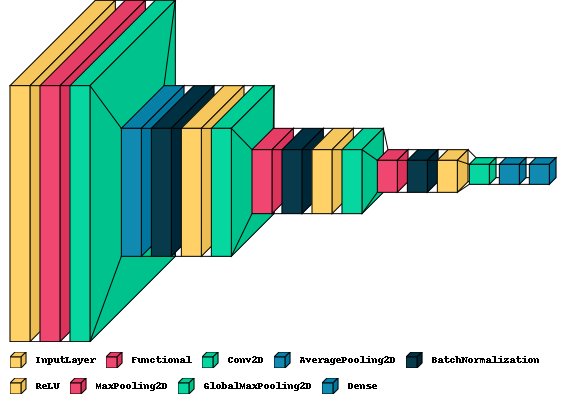

In [ ]:
#@markdown Visualize a random model

visualkeras.layered_view(models[1],legend=True,spacing=10)

In [ ]:
#@markdown Select best models based on validation accuracy:
VAL_ACC_THRESHOLD = 0.89 #@param
print('Evaluated models:')
selected_models =\
    [m for m in models if m.evaluate(validation_ds)[1]>VAL_ACC_THRESHOLD]

display.Javascript("google.colab.output.setIframeHeight('200px');")

Evaluated models:
8/8 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.8664


<IPython.core.display.Javascript object>

In [ ]:
#@markdown Build the final 'Average ensemble' model

#Fix merge name conflict
i = 0
for model in selected_models:
    model._name = "model64_" + str(i)
    i += 1

#Create an average ensemble for prediction
input = keras.Input(shape=(64,64,3))
y = [model(input) for model in selected_models]
output = keras.layers.average(y)
ensemble_model = keras.Model(inputs=input, outputs=output)
ensemble_model.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy"])
print("Evaluation on validation data:")
ensemble_model.evaluate(validation_ds)
print("Evaluation on test data:")
avg_ensemble_perf = ensemble_model.evaluate(test_ds)

Evaluation on validation data:
8/8 [==============================] - 1s 16ms/step - loss: 0.2811 - accuracy: 0.9065
Evaluation on test data:
8/8 [==============================] - 0s 16ms/step - loss: 0.2941 - accuracy: 0.8783


In [ ]:
#@markdown We make a comparison with a 'Majority voting ensemble', and we find
#@markdown same performance of the 'Average ensemble' built before.

#@markdown [Evaluated on test data]

#Majority voting ensemble performance comparison
predictions = [model.predict(test_ds) for model in selected_models]
predictions = np.array(predictions)
summed = np.sum(predictions, axis=0)
predicted_labels = np.array([int(x==True) for x in summed/len(selected_models)>=0.5])

true_labels = np.array([])
for sample in test_ds.take(100):
    for true_label in sample[1]:
        true_labels = np.append(true_labels,true_label)

maj_vot_perf = np.sum(predicted_labels==true_labels)/len(predicted_labels)
print("'Average ensemble' performance: {:.5f}".format(avg_ensemble_perf[1]))
print("'Majority voting ensemble' performance: {:.5f}".format(maj_vot_perf))

'Average ensemble' performance: 0.87832
'Majority voting ensemble' performance: 0.87832


Since the 'Average ensemble' is easier to 

<IPython.core.display.Javascript object>

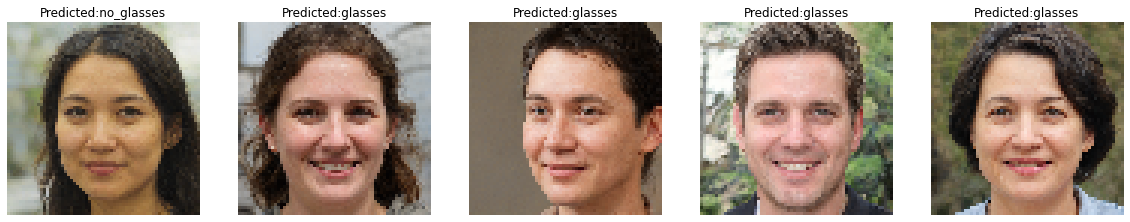

In [ ]:
#@markdown We plot some wrong predicted images to examine where the classifier
#@markdown fails:

predicted = ensemble_model.predict(test_ds)

fig, axs = plt.subplots(1,5)
fig.set_size_inches(20,10)
ax = 1
i = 0
for sample in test_ds.take(100):
    images = sample[0]
    true_labels = sample[1]
    for true_label in true_labels:
        #print("Predicted:{}  True:{}".format(round(predicted[i][0]),true_label[0]))
        predicted_label = round(predicted[i][0])
        if predicted_label != true_label[0]:
            plt.subplot(1,5,ax)
            plt.imshow((images[i%64]*255).numpy().astype(np.uint8))
            plt.title('Predicted:{}'.format('glasses' if predicted_label else 'no_glasses'))
            plt.axis("off")
            ax += 1
            if ax > 5:
                break
        i += 1
    if ax > 5:
        break
        

display.Javascript("google.colab.output.setIframeHeight('250px');")

Apparently there are some errors in the true labels, since we find inconsistencies in some of the 'wrong predicted images' plotted.  
In fact, even the author of the dataset draws attention to the presence of missclassified data.
These label errors can be interpreted, in a statistical learning framework, as stochasticity in the label values. And all the errors contributes to the statistical Bayer error.  
Therefore, we will never be able to retrieve a perfect classifier (but we can train longer and hope to get a better accuracy, since there are some true 'wrong predicted images').

# Extra: 512-dimensional latent vectors analysis

In [ ]:
#@markdown Prepare train, val and test sets
latent_features = latent_features_csv.iloc[:,1:-1].compute().to_numpy()
labels = latent_features_csv.iloc[:,-1].compute().to_numpy()

latent_features_train,\
latent_features_val,\
labels_train,\
labels_val = train_test_split(
    latent_features,
    labels,
    train_size=0.8,
    random_state=1337,
    stratify=labels)
latent_features_val,\
latent_features_test,\
labels_val,\
labels_test = train_test_split(
    latent_features_val,
    labels_val,
    train_size=0.5,
    random_state=1337,
    stratify=labels_val)

In [ ]:
#@markdown Build and train a toy neural network
input_layer = Input(shape=(512,))
x = Dense(128, activation="relu")(input_layer)
x = Dense(16, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
latent_model = Model(input_layer, x)
latent_model.compile(optimizer="adam",
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
history = latent_model.fit(latent_features_train,
                           labels_train,
                           batch_size=64,
                           epochs=5,
                           validation_data=(latent_features_val,labels_val))

Epoch 1/5
57/57 [==============================] - 1s 7ms/step - loss: 0.4901 - accuracy: 0.7278 - val_loss: 0.1064 - val_accuracy: 0.9889
Epoch 2/5
57/57 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9963 - val_loss: 0.0246 - val_accuracy: 0.9978
Epoch 3/5
57/57 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9978
Epoch 4/5
57/57 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9978
Epoch 5/5
57/57 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9978


In [ ]:
#@markdown Evaluate on test set
res = latent_model.evaluate(latent_features_test, labels_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.9956
